In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, ActivityRegularization, Lambda, Concatenate, Permute, Convolution1D, MaxPooling1D, AveragePooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import concatenate, dot
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda, concatenate, Add
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, LeakyReLU

from tensorflow.keras.models import Sequential, Model



from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

from matplotlib.legend_handler import HandlerLine2D
from matplotlib.colors import LogNorm
import pylab as pyy
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from functools import partial
import matplotlib.pyplot as plt
from matplotlib import colors as mcol

# import pylab as py
# from tools import load, save, checkdir
import pandas as pd
from matplotlib.lines import Line2D

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-lqagy1sj because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [5]:
data = np.load("inverse_mappers/GAN/eICU_age.npy")
data.shape

(2520,)

In [6]:
data= data['age']
data= np.array(data).reshape(-1,1)
data.shape

(2520, 1)

In [7]:
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler,StandardScaler, QuantileTransformer, PowerTransformer
data_sc= QuantileTransformer(output_distribution='normal')# minmax
data_scaled = data_sc.fit_transform(data) 

In [8]:
clas = data_scaled

In [19]:
class LSGAN():
    def __init__(self):
        self.img_shape = (clas.shape[1],)
        self.latent_dim = 100

        optimizer = Adam(0.00001, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        generator_noise = Input(shape=(self.latent_dim,))
        img = self.generator(generator_noise)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model(generator_noise, valid )
        # (!!!) Optimize w.r.t. MSE loss instead of crossentropy
#         MMD_loss = self.MMD_loss()
        self.combined.compile(loss='mse', optimizer=optimizer)
        
    

    def build_generator(self):
        noise = Input(shape=(100,))
        
        rate = 0.000000000001
        x11 = Dense(512)(noise)
        x1 = BatchNormalization(momentum=0.8)(x11)
        x1 = LeakyReLU(alpha=0.2)(x1)
        

        x2 = Dense(512)(x1)
        x2 = BatchNormalization(momentum=0.8)(x2)
        x2 = LeakyReLU(alpha=0.2)(x2)
        

        x3 = Dense(512)(x2)
         
        sc11 = Add()([x11, x3])
        sc1 = BatchNormalization(momentum=0.8)(sc11)
        sc1 = LeakyReLU(alpha=0.2)(sc1)
        

        x4 = Dense(512)(sc1)
        x4 = BatchNormalization(momentum=0.8)(x4)
        x4 = LeakyReLU(alpha=0.2) (x4)
        
        
        x5 = Dense(512)(x4)
        
        sc22 = Add()([sc11, x5])
        sc2 = BatchNormalization(momentum=0.8)(sc22)
        sc2 = LeakyReLU(alpha=0.2)(sc2)
        
        x6 = Dense(512)(sc2)
        x6 = BatchNormalization(momentum=0.8)(x6)
        x6 = LeakyReLU(alpha=0.2) (x6)
        
        x7 = Dense(512)(x6)
        
        sc33 = Add()([sc22, x7])
        sc3 = BatchNormalization(momentum=0.8)(sc33)
        sc3 = LeakyReLU(alpha=0.2)(sc3)
        
        
        x8 = Dense(512)(sc3)
        x8 = BatchNormalization(momentum=0.8)(x8)
        x8 = LeakyReLU(alpha=0.2) (x8)
        
        x9 = Dense(512)(x8)
        
        sc44 = Add()([sc33, x9])
        sc4 = BatchNormalization(momentum=0.8)(sc44)
        sc4 = LeakyReLU(alpha=0.2)(sc4)
        
        

        output = Dense(1)(sc4)
        #features = Lambda(self.feature_mul)(output2)
        #outputmerge = concatenate([output2, features])
        generator = Model(inputs=noise, outputs=[output,sc4 ])
        generator.summary()
        return(generator)


    def build_discriminator(self):
        rate = 0.2
        
        vis = Input(shape=(clas.shape[1],))
        
        x11 = Dense(512)(vis)
        #x1 = BatchNormalization(momentum=0.8)(x11)
        x1 = LeakyReLU(alpha=0.2)(x11)
        x1 = Dropout(rate)(x1)
        

        x2 = Dense(512)(x1)
        #x2 = BatchNormalization(momentum=0.8)(x2)
        x2 = LeakyReLU(alpha=0.2)(x2)
        x2 = Dropout(rate)(x2)
        

        x3 = Dense(512)(x2)
         
        sc11 = Add()([x11, x3])
        #sc1 = BatchNormalization(momentum=0.8)(sc11)
        sc1 = LeakyReLU(alpha=0.2)(sc11)
        sc1 = Dropout(rate)(sc1)
        

        x4 = Dense(512)(sc1)
        #x4 = BatchNormalization(momentum=0.8)(x4)
        x4 = LeakyReLU(alpha=0.2) (x4)
        x4 = Dropout(rate)(x4)
        
        
        x5 = Dense(512)(x4)
        
        sc22 = Add()([sc11, x5])
        #sc2 = BatchNormalization(momentum=0.8)(sc22)
        sc2 = LeakyReLU(alpha=0.2)(sc22)
        sc2 = Dropout(rate)(sc2)
        
        
        x6 = Dense(512)(sc2)
        #x6 = BatchNormalization(momentum=0.8)(x6)
        x6 = LeakyReLU(alpha=0.2) (x6)
        x6 = Dropout(rate)(x6)
        
        
        x7 = Dense(512)(x6)
        
        sc33 = Add()([sc22, x7])
        #sc3 = BatchNormalization(momentum=0.8)(sc33)
        sc3 = LeakyReLU(alpha=0.2)(sc33)
        sc3 = Dropout(rate)(sc3)
        
        
        x8 = Dense(512)(sc3)
        #x8 = BatchNormalization(momentum=0.8)(x8)
        x8 = LeakyReLU(alpha=0.2) (x8)
        x8 = Dropout(rate)(x8)
        
        x9 = Dense(512)(x8)
        
        sc44 = Add()([sc33, x9])
        #sc4 = BatchNormalization(momentum=0.8)(sc44)
        sc4 = LeakyReLU(alpha=0.2)(sc44)
        sc4 = Dropout(rate)(sc4)
        
        # (!!!) No softmax
        output = Dense(1)(sc4)

        discriminator = Model(inputs=vis, outputs=[output,sc4])
        discriminator.summary()
        return(discriminator)
    
    

    def train(self, epochs, batch_size=128, sample_interval=50):
        
                  
        X_train = clas
        print(X_train.shape)
        

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

#         self.generator.load_weights('ls_generator.h5')
#         self.discriminator.load_weights('ls_discriminator.h5')
        
        dloss=[]
        gloss=[]
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise, verbose = 0)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, [valid, imgs])

            # Plot the progress
            #print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            #loss_gen.append(g_loss[0])
            #loss_dis.append(d_loss[0])
            

            # If at save interval => save generated image samples
            dloss=np.append(dloss,d_loss[0])
            gloss=np.append(gloss,g_loss)
            if epoch % sample_interval == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
                self.sample_images(epoch, dloss, gloss)
                #self.generator.save_weights('/work/JAM/yasir/models/ls_generator_res_error_fixed_0.h5')
                #self.discriminator.save_weights('/work/JAM/yasir/models/ls_discriminator_res_error_fixed_0.h5')
                
                #self.generator.save_weights('ls_generator_fat_free.h5')
                #self.discriminator.save_weights('ls_discriminator_fat_free.h5')
                
                print('saved ...')
                
#                 self.discriminator.save_weights('ls_discriminator_all'+str(epoch)+'.h5')




    def sample_images(self, epoch, dloss, gloss):

        SAMPLE_SIZE = clas.shape[0] 
        noise = np.random.normal(0, 1, (SAMPLE_SIZE, 100))
        

        results = self.generator.predict(noise, batch_size = 20000)
        
        plt.hist(np.round(data_sc.inverse_transform(results)), bins = 100, histtype = 'step',label="GAN")
        plt.hist(data, bins = 100, histtype = 'step', label= "True")
        plt.xlim(data.min(),data.max())
        plt.legend()
        plt.show()


        
  

        nrows,ncols=1,1
        fig = pyy.figure(figsize=(ncols*7,nrows*5))

        ax=pyy.subplot(nrows,ncols,1)
        ax.plot(range(1,len(gloss)+1),gloss,label=r'$\rm generator$')
        ax.plot(range(1,len(dloss)+1),dloss,label=r'$\rm discriminator$')
        ax.semilogy()
        ax.semilogx()
        ax.legend(fontsize=20)
        ax.set_ylabel(r'$\rm Loss$',size=20)
        ax.set_xlabel(r'$\rm epochs$',size=20)
        ax.tick_params(axis='both', which='both', labelsize=15,direction='in')
        plt.show()
        

In [20]:
gan = LSGAN()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_20 (Dense)               (None, 512)          1024        ['input_4[0][0]']                
                                                                                                  
 leaky_re_lu_18 (LeakyReLU)     (None, 512)          0           ['dense_20[0][0]']               
                                                                                                  
 dropout_9 (Dropout)            (None, 512)          0           ['leaky_re_lu_18[0][0]']         
                                                                                            

In [21]:


# gan.generator.save_weights('/work/JAM/almaeen/ls_generato.h5')
# gan.discriminator.save_weights('/work/JAM/almaeen/ls_discriminator.h5')

In [22]:
gan.generator.load_weights('/work/JAM/almaeen/ls_generato.h5')
gan.discriminator.load_weights('/work/JAM/almaeen/ls_discriminator.h5')


In [23]:
#gan.train(epochs=5000000, batch_size=128, sample_interval=200)

In [24]:

SAMPLE_SIZE = clas.shape[0] 
noise = np.random.normal(0, 1, (SAMPLE_SIZE, 100))


results, LL = gan.generator.predict(noise, batch_size = 20000)






1/1 [==============================] - 0s 284ms/step


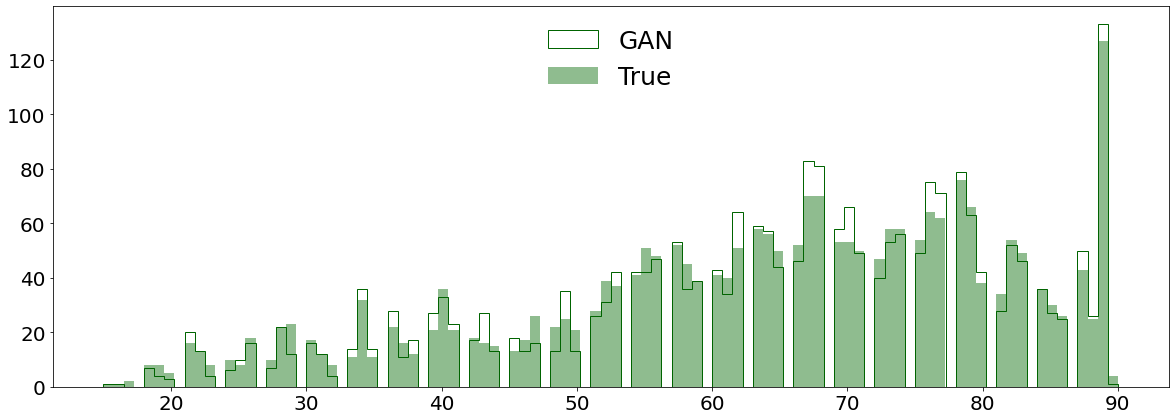

In [64]:
plt.figure(figsize=(20,7))

plt.hist(np.round(data_sc.inverse_transform(results)), bins = 100, histtype = 'step',color='darkgreen',label="GAN")
plt.hist(data, bins = 100,color='darkseagreen', label= "True")
# plt.xlim(data.min(),data.max())
plt.legend(loc = 'upper center', fontsize = 25, frameon = 0)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.savefig("Gan.png")
plt.show()

